In [ ]:
pip install scikit-learn dgeb torch pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import dgeb
from functools import partial
from dgeb.evaluators import Evaluator

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    label_ranking_average_precision_score,
)

from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from dgeb.models import BioSeqTransformer
from dgeb.tasks import Task, TaskMetadata, TaskResult,Dataset
from collections import defaultdict
from dgeb.eval_utils import merge_split_elem_embeds
from dgeb.modality import Modality


In [ ]:


DEFAULT_BATCH_SIZE = 32
DEFAULT_SEQ_LEN = 1024

get_model = partial(
    dgeb.get_model,
    batch_size=DEFAULT_BATCH_SIZE,
    max_seq_length=DEFAULT_SEQ_LEN,
)

model_small = get_model("facebook/esm2_t6_8M_UR50D")
model_large = get_model("facebook/esm2_t12_35M_UR50D")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# Get the primary metric ID (e.g., "f1")
def get_results(results):
  f1_score = None
  accuracy = None

  last_layer = results.results[-1]
  return last_layer

def get_cluster_results(results):

  points = []
  last_layer = results.results[-1]

  for metric in last_layer.metrics:
      if not metric.id.startswith("f1"):
        label = metric.id.rsplit("_", 1)[0]  # Remove the numeric suffix
        points.append({"label": label, "cluster": metric.value})

  return points

def get_primary_scores(results):
  f1_score = None
  accuracy = None

  last_layer = results.results[-1]
  for metric in last_layer.metrics:
    if metric.id == "accuracy":
        accuracy = metric.value
    elif metric.id == "f1":
        f1_score = metric.value

  return f1_score, accuracy



In [ ]:

class MultiClassMultiOutputRFClassificationEvaluator(Evaluator):
    def __init__(
        self,
        embeds_train,
        y_train,
        embeds_test,
        y_test,
        n_estimators=100,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.embeds_train = embeds_train
        self.y_train = y_train
        self.embeds_test = embeds_test
        self.y_test = y_test
        self.n_estimators = n_estimators

    def __call__(self):
        scores = {}

        mlb = MultiLabelBinarizer()
        class_labels = list(self.y_train) + list(self.y_test)
        labels = [label.split(", ") for label in class_labels]
        mlb.fit(labels)

        y_train_bin = mlb.transform([label.split(", ") for label in self.y_train])
        y_test_bin = mlb.transform([label.split(", ") for label in self.y_test])

        clf = RandomForestClassifier(n_estimators=self.n_estimators, random_state=42)
        print("Fitting Random Forest classifier...")
        clf.fit(self.embeds_train, y_train_bin)
        print("Evaluating...")
        y_pred = clf.predict(self.embeds_test)

        scores["accuracy"] = accuracy_score(y_test_bin, y_pred)
        scores["f1"] = f1_score(y_test_bin, y_pred, average="macro")
        scores["precision"] = precision_score(y_test_bin, y_pred, average="macro")
        scores["recall"] = recall_score(y_test_bin, y_pred, average="macro")
        scores["lrap"] = label_ranking_average_precision_score(y_test_bin, y_pred)

        return scores


In [ ]:
from sklearn.neural_network import MLPClassifier

class MultiClassMultiOutputNNClassificationEvaluator(Evaluator):
    def __init__(
        self,
        embeds_train,
        y_train,
        embeds_test,
        y_test,
        hidden_layer_sizes=(100,),
        max_iter=200,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.embeds_train = embeds_train
        self.y_train = y_train
        self.embeds_test = embeds_test
        self.y_test = y_test
        self.hidden_layer_sizes = hidden_layer_sizes
        self.max_iter = max_iter

    def __call__(self):
        scores = {}

        # Binarize multilabel targets
        mlb = MultiLabelBinarizer()
        class_labels = list(self.y_train) + list(self.y_test)
        labels = [label.split(", ") for label in class_labels]
        mlb.fit(labels)

        y_train_bin = mlb.transform([label.split(", ") for label in self.y_train])
        y_test_bin = mlb.transform([label.split(", ") for label in self.y_test])

        # Define and train MLP classifier
        clf = MLPClassifier(
            hidden_layer_sizes=self.hidden_layer_sizes,
            max_iter=self.max_iter,
            random_state=42
        )
        print("Fitting Neural Network (MLPClassifier)...")
        clf.fit(self.embeds_train, y_train_bin)

        print("Evaluating...")
        y_pred = clf.predict(self.embeds_test)

        # Calculate metrics
        scores["accuracy"] = accuracy_score(y_test_bin, y_pred)
        scores["f1"] = f1_score(y_test_bin, y_pred, average="macro")
        scores["precision"] = precision_score(y_test_bin, y_pred, average="macro")
        scores["recall"] = recall_score(y_test_bin, y_pred, average="macro")
        scores["lrap"] = label_ranking_average_precision_score(y_test_bin, y_pred)

        return scores


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    label_ranking_average_precision_score
)
from collections import defaultdict
import numpy as np
import random

class FewShotNNClassificationEvaluator(Evaluator):
    def __init__(
        self,
        embeds_train,
        y_train,
        embeds_test,
        y_test,
        k_shot=5,
        hidden_layer_sizes=(100,),
        max_iter=200,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.embeds_train = embeds_train
        self.y_train = y_train
        self.embeds_test = embeds_test
        self.y_test = y_test
        self.k_shot = k_shot
        self.hidden_layer_sizes = hidden_layer_sizes
        self.max_iter = max_iter

    def sample_few_shot(self):
        """Sample k-shot examples per label."""
        label_to_indices = defaultdict(list)
        for idx, label_str in enumerate(self.y_train):
            for label in label_str.split(", "):
                label_to_indices[label].append(idx)

        selected_indices = set()
        for label, indices in label_to_indices.items():
            if len(indices) >= self.k_shot:
                chosen = random.sample(indices, self.k_shot)
            else:
                chosen = indices  # use all if not enough
            selected_indices.update(chosen)

        selected_indices = list(selected_indices)
        return (
            [self.embeds_train[i] for i in selected_indices],
            [self.y_train[i] for i in selected_indices],
        )

    def __call__(self):
        scores = {}

        # Prepare few-shot training set
        fewshot_embeds, fewshot_labels = self.sample_few_shot()

        # Binarize multilabel targets
        mlb = MultiLabelBinarizer()
        all_labels = [label.split(", ") for label in list(self.y_train) + list(self.y_test)]

        mlb.fit(all_labels)

        y_train_bin = mlb.transform([label.split(", ") for label in fewshot_labels])
        y_test_bin = mlb.transform([label.split(", ") for label in self.y_test])

        # Train classifier
        clf = MLPClassifier(
            hidden_layer_sizes=self.hidden_layer_sizes,
            max_iter=self.max_iter,
            random_state=42
        )
        print(f"Fitting MLPClassifier on {len(fewshot_embeds)} few-shot examples...")
        clf.fit(fewshot_embeds, y_train_bin)

        # Predict
        print("Evaluating...")
        y_pred = clf.predict(self.embeds_test)

        # Metrics
        scores["accuracy"] = accuracy_score(y_test_bin, y_pred)
        scores["f1"] = f1_score(y_test_bin, y_pred, average="macro")
        scores["precision"] = precision_score(y_test_bin, y_pred, average="macro")
        scores["recall"] = recall_score(y_test_bin, y_pred, average="macro")
        scores["lrap"] = label_ranking_average_precision_score(y_test_bin, y_pred)

        return scores


In [ ]:
from sklearn.cluster import KMeans
from collections import defaultdict
import numpy as np

class MultiClassMultiOutputClusteringEvaluator(Evaluator):
    def __init__(
        self,
        embeds_train,
        y_train,
        embeds_test,
        y_test,
        n_clusters=6,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.embeds_train = embeds_train
        self.y_train = y_train
        self.embeds_test = embeds_test
        self.y_test = y_test
        self.n_clusters = n_clusters

    def __call__(self):
        # Combine train and test
        X = np.vstack((self.embeds_train, self.embeds_test))
        y = list(self.y_train) + list(self.y_test)

        # Split labels
        label_lists = [label.split(", ") for label in y]

        # Clustering
        print(f"Fitting KMeans with {self.n_clusters} clusters...")
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        cluster_ids = kmeans.fit_predict(X)

        # Generate output mapping
        result = {}
        label_counters = defaultdict(int)

        for i, (labels, cluster_id) in enumerate(zip(label_lists, cluster_ids)):
            for label in labels:
                label_id = f"{label}_{label_counters[label]}"
                result[label_id] = cluster_id
                label_counters[label] += 1

        result["f1"] = -1

        return result


In [ ]:
from typing import Type

def run_task(
    model: BioSeqTransformer,
    metadata: TaskMetadata,
    evaluator_cls: Type[Evaluator],
    **evaluator_kwargs
) -> TaskResult:
    """
    Evaluate on MIBIG classification tasks. Multiclass, multi-label classification evaluator is passed as a parameter.
    """
    ds = metadata.datasets[0].load()
    if metadata.modality == dgeb.Modality.DNA:
        # MIBiG DNA sequences can be very long. Instead of truncating to max_seq_length,
        # split into multiple sequences and mean pool the resulting embeddings.
        ds = dgeb.split_sequences(ds, model.max_seq_length)

    layer_results = defaultdict(dict)

    train_embeds = model.encode(ds["train"]["Sequence"])
    test_embeds = model.encode(ds["test"]["Sequence"])

    train_ids = ds["train"]["Entry"]
    test_ids = ds["test"]["Entry"]
    train_labels = ds["train"]["class"]
    test_labels = ds["test"]["class"]

    train_id_to_label = {id: label for id, label in zip(train_ids, train_labels)}
    test_id_to_label = {id: label for id, label in zip(test_ids, test_labels)}
    # Mean pool embeds with the same ID.
    train_ids, train_embeds = merge_split_elem_embeds(train_ids, train_embeds)
    test_ids, test_embeds = merge_split_elem_embeds(test_ids, test_embeds)
    # Gather the labels after merging by unique ID.
    train_labels = np.array([train_id_to_label[id] for id in train_ids])
    test_labels = np.array([test_id_to_label[id] for id in test_ids])

    for i, layer in enumerate(model.layers):
        evaluator = evaluator_cls(
            train_embeds[:, i],
            train_labels,
            test_embeds[:, i],
            test_labels,
            **evaluator_kwargs
        )
        layer_results["layers"][layer] = evaluator()

    return TaskResult.from_dict(metadata, layer_results, model.metadata)


In [ ]:

class RFMIBiGProteinClassification(Task):
    metadata = TaskMetadata(
        id="MIBIG_protein_classification",
        display_name="MIBiG Classification",
        description="Biosynthetic Gene cluster classification using protein sequences on MIBIG dataset.",
        type="classification",
        modality=Modality.PROTEIN,
        datasets=[
            Dataset(
                path="tattabio/mibig_classification_prot",
                revision="915a7ff28dc9820e35c4d7fd03d4c8c44a88ff1f",
            )
        ],
        primary_metric_id="f1",
    )

    def run(self, model: BioSeqTransformer) -> TaskResult:
        return run_task(model, self.metadata,   evaluator_cls=MultiClassMultiOutputRFClassificationEvaluator,
    n_estimators=100)

In [ ]:

class NNMIBiGProteinClassification(Task):
    metadata = TaskMetadata(
        id="MIBIG_protein_classification",
        display_name="MIBiG Classification",
        description="Biosynthetic Gene cluster classification using protein sequences on MIBIG dataset.",
        type="classification",
        modality=Modality.PROTEIN,
        datasets=[
            Dataset(
                path="tattabio/mibig_classification_prot",
                revision="915a7ff28dc9820e35c4d7fd03d4c8c44a88ff1f",
            )
        ],
        primary_metric_id="f1",
    )

    def run(self, model: BioSeqTransformer) -> TaskResult:
        return run_task(model, self.metadata,   evaluator_cls=MultiClassMultiOutputNNClassificationEvaluator,
    )

In [ ]:

class FewShotMIBiGProteinClassification(Task):
    metadata = TaskMetadata(
        id="MIBIG_protein_classification",
        display_name="MIBiG Classification",
        description="Biosynthetic Gene cluster classification using protein sequences on MIBIG dataset.",
        type="classification",
        modality=Modality.PROTEIN,
        datasets=[
            Dataset(
                path="tattabio/mibig_classification_prot",
                revision="915a7ff28dc9820e35c4d7fd03d4c8c44a88ff1f",
            )
        ],
        primary_metric_id="f1",
    )

    def run(self, model: BioSeqTransformer) -> TaskResult:
        return run_task(model, self.metadata,   evaluator_cls=FewShotNNClassificationEvaluator,
    n_estimators=100)

In [ ]:

class ClusteringMIBiGProteinClassification(Task):
    metadata = TaskMetadata(
        id="MIBIG_protein_classification",
        display_name="MIBiG Classification",
        description="Biosynthetic Gene cluster classification using protein sequences on MIBIG dataset.",
        type="classification",
        modality=Modality.PROTEIN,
        datasets=[
            Dataset(
                path="tattabio/mibig_classification_prot",
                revision="915a7ff28dc9820e35c4d7fd03d4c8c44a88ff1f",
            )
        ],
        primary_metric_id="f1",

    )

    def run(self, model: BioSeqTransformer) -> TaskResult:
        return run_task(model, self.metadata,   evaluator_cls=MultiClassMultiOutputClusteringEvaluator,
   )

In [ ]:

knn_small_results = dgeb.tasks.MIBiGProteinClassification().run(model=model_small)
knn_small_f1, knn_small_accuracy = get_primary_scores(knn_small_results)
print(f"KNN (Small Model) F1 score: {knn_small_f1}")
print(f"KNN (Small Model) Accuracy: {knn_small_accuracy}")

knn_large_results = dgeb.tasks.MIBiGProteinClassification().run(model=model_large)
knn_large_f1, knn_large_accuracy = get_primary_scores(knn_large_results)
print(f"KNN (Large Model) F1 score: {knn_large_f1}")
print(f"KNN (Large Model) Accuracy: {knn_large_accuracy}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
encoding: 100%|██████████| 226/226 [02:00<00:00,  1.88it/s]


KNN (Small Model) F1 score: 0.6539081896462444
KNN (Small Model) Accuracy: 0.6825396825396826


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
encoding: 100%|██████████| 226/226 [04:47<00:00,  1.27s/it]


KNN (Large Model) F1 score: 0.645844633541225
KNN (Large Model) Accuracy: 0.655328798185941


In [ ]:
rf_small_results = RFMIBiGProteinClassification().run(model=model_small)
rf_small_f1, rf_small_accuracy = get_primary_scores(rf_small_results)
print(f"rf (Small Model) F1 score: {rf_small_f1}")
print(f"rf (Small Model) Accuracy: {rf_small_accuracy}")

encoding: 100%|██████████| 226/226 [00:35<00:00,  6.45it/s]


Fitting Random Forest classifier...
Evaluating...
Fitting Random Forest classifier...
Evaluating...
rf (Small Model) F1 score: 0.6161700360211948
rf (Small Model) Accuracy: 0.6621315192743764


In [ ]:
rf_large_results = RFMIBiGProteinClassification().run(model=model_large)
rf_large_f1, rf_large_accuracy = get_primary_scores(rf_large_results)
print(f"rf (Large Model) F1 score: {rf_large_f1}")
print(f"rf (Large Model) Accuracy: {rf_large_accuracy}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
encoding: 100%|██████████| 226/226 [01:27<00:00,  2.58it/s]


Fitting Random Forest classifier...
Evaluating...
Fitting Random Forest classifier...
Evaluating...
rf (Large Model) F1 score: 0.6378866879409789
rf (Large Model) Accuracy: 0.655328798185941


In [ ]:
nn_small_results = NNMIBiGProteinClassification().run(model=model_small)
nn_small_f1, nn_small_accuracy = get_primary_scores(nn_small_results)
print(f"nn (Small Model) F1 score: {nn_small_f1}")
print(f"nn (Small Model) Accuracy: {nn_small_accuracy}")

NameError: name 'model' is not defined

In [ ]:
nn_large_results = NNMIBiGProteinClassification().run(model=model_large)
nn_large_f1, nn_large_accuracy = get_primary_scores(nn_large_results)
print(f"nn (Large Model) F1 score: {nn_large_f1}")
print(f"nn (Large Model) Accuracy: {nn_large_accuracy}")


In [ ]:
few_small_results = FewShotMIBiGProteinClassification().run(model=model_small)
few_small_f1, few_small_accuracy = get_primary_scores(few_small_results)
print(f"zero (Small Model) F1 score: {few_small_f1}")
print(f"zero (Small Model) Accuracy: {few_small_accuracy}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
encoding: 100%|██████████| 226/226 [02:00<00:00,  1.88it/s]


Fitting MLPClassifier on 30 few-shot examples...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating...
Fitting MLPClassifier on 30 few-shot examples...
Evaluating...
zero (Small Model) F1 score: 0.5171384578846975
zero (Small Model) Accuracy: 0.40816326530612246


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
few_large_results = FewShotMIBiGProteinClassification().run(model=model_large)
few_large_f1, few_large_accuracy = get_primary_scores(few_large_results)
print(f"zero (Large Model) F1 score: {few_large_f1}")
print(f"zero (Large Model) Accuracy: {few_large_accuracy}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
encoding: 100%|██████████| 226/226 [04:47<00:00,  1.27s/it]


Fitting MLPClassifier on 30 few-shot examples...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating...
Fitting MLPClassifier on 30 few-shot examples...
Evaluating...
zero (Large Model) F1 score: 0.5363740931624192
zero (Large Model) Accuracy: 0.40816326530612246


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
small_clustering_results = ClusteringMIBiGProteinClassification().run(model=model_small)


['Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'Polyketide', '

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
encoding: 100%|██████████| 226/226 [02:02<00:00,  1.84it/s]


Fitting KMeans with 6 clusters...
Fitting KMeans with 6 clusters...


In [ ]:
parsed_small_cluster_results = get_cluster_results(small_clustering_results)
parsed_small_cluster_results

[{'label': 'Polyketide', 'cluster': 4.0},
 {'label': 'Polyketide', 'cluster': 2.0},
 {'label': 'Polyketide', 'cluster': 3.0},
 {'label': 'Polyketide', 'cluster': 1.0},
 {'label': 'Polyketide', 'cluster': 1.0},
 {'label': 'Polyketide', 'cluster': 1.0},
 {'label': 'Polyketide', 'cluster': 1.0},
 {'label': 'Polyketide', 'cluster': 1.0},
 {'label': 'Polyketide', 'cluster': 2.0},
 {'label': 'Polyketide', 'cluster': 3.0},
 {'label': 'Alkaloid', 'cluster': 3.0},
 {'label': 'Polyketide', 'cluster': 4.0},
 {'label': 'Polyketide', 'cluster': 4.0},
 {'label': 'Polyketide', 'cluster': 4.0},
 {'label': 'Polyketide', 'cluster': 3.0},
 {'label': 'Polyketide', 'cluster': 2.0},
 {'label': 'Polyketide', 'cluster': 2.0},
 {'label': 'Polyketide', 'cluster': 4.0},
 {'label': 'Saccharide', 'cluster': 4.0},
 {'label': 'Polyketide', 'cluster': 2.0},
 {'label': 'Polyketide', 'cluster': 4.0},
 {'label': 'Polyketide', 'cluster': 3.0},
 {'label': 'Polyketide', 'cluster': 4.0},
 {'label': 'Polyketide', 'cluster': 

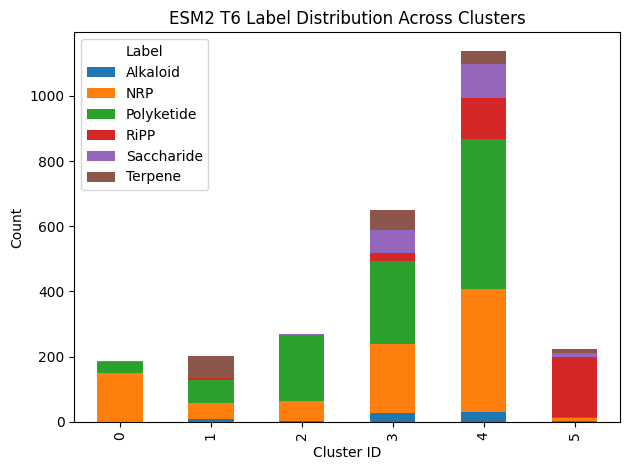

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_cluster_results(results, title):
  df = pd.DataFrame(results)
  df['cluster'] = df['cluster'].astype(int)

  # Count occurrences of each label in each cluster
  cluster_counts = df.groupby(['cluster', 'label']).size().unstack(fill_value=0)

  # Plot
  cluster_counts.plot(kind='bar', stacked=True)
  plt.title(f'{title} Label Distribution Across Clusters')
  plt.xlabel('Cluster ID')
  plt.ylabel('Count')
  plt.legend(title='Label')
  plt.tight_layout()
  plt.show()

plot_cluster_results(parsed_small_cluster_results, "ESM2 T6")

In [ ]:
large_clustering_results = ClusteringMIBiGProteinClassification().run(model=model_large)
parsed_large_cluster_results = get_cluster_results(large_clustering_results)



['Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Polyketide', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'Alkaloid', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'NRP', 'Polyketide', '

encoding: 100%|██████████| 226/226 [04:58<00:00,  1.32s/it]


Fitting KMeans with 6 clusters...
Fitting KMeans with 6 clusters...


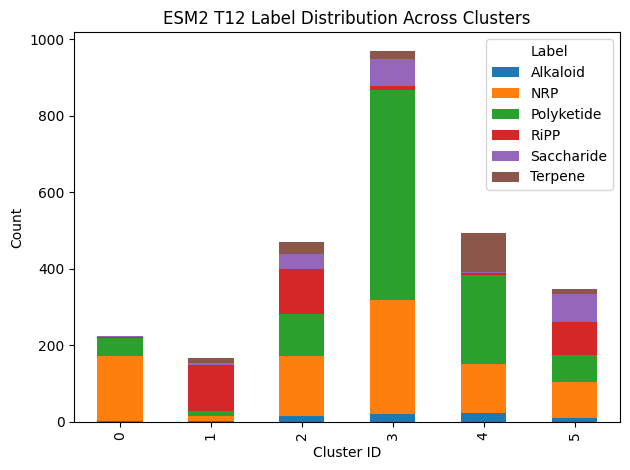

In [ ]:
plot_cluster_results(parsed_large_cluster_results,"ESM2 T12")

In [ ]:
label_df = pd.read_csv("labels.csv")

# plot bar chart of correct clustering where class is the x axis. And y is count


,class,index
0,RiPP,0
1,Saccharide,1
2,Saccharide,2
3,Saccharide,3
4,Saccharide,4


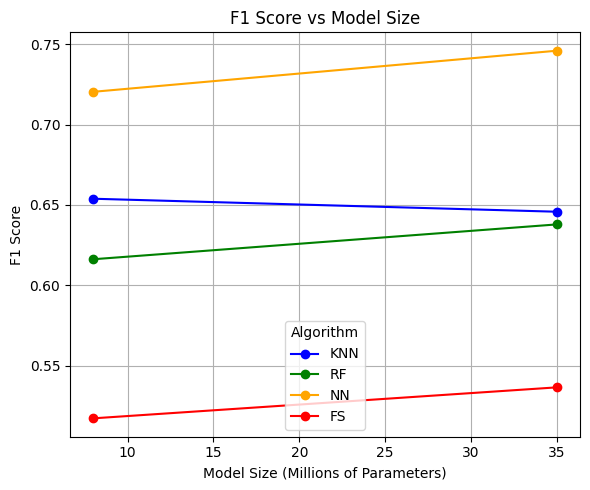

In [ ]:
plt.figure(figsize=(6, 5))
for algo in colors:
    xs = [m[2] for m in models if m[0] == algo]
    ys = [m[3] for m in models if m[0] == algo]
    plt.plot(xs, ys, 'o-', color=colors[algo], label=algo)

plt.xlabel("Model Size (Millions of Parameters)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Model Size")
plt.grid(True)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()

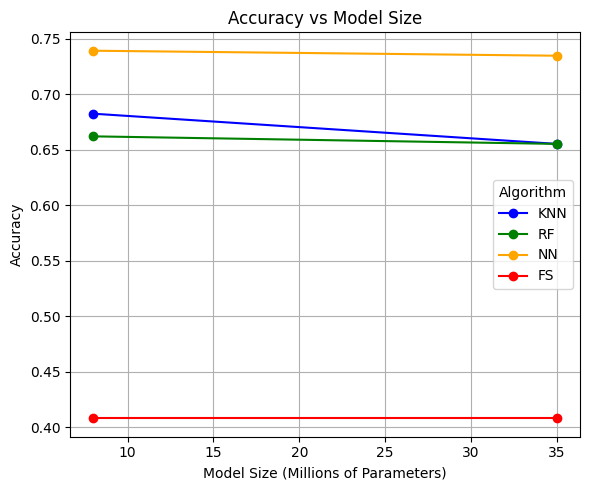

In [ ]:
import matplotlib.pyplot as plt

# Data for Accuracy
models = [
    ("KNN", "T6", 8, 0.6825),
    ("KNN", "T12", 35, 0.6553),
    ("RF", "T6", 8, 0.6621),
    ("RF", "T12", 35, 0.6553),
    ("NN", "T6", 8, 0.7392),
    ("NN", "T12", 35, 0.7347),
    ("FS", "T6", 8, 0.4082),
    ("FS", "T12", 35, 0.4082),
]

colors = {
    "KNN": "blue",
    "RF": "green",
    "NN": "orange",
    "FS": "red"
}

plt.figure(figsize=(6, 5))
for algo in colors:
    xs = [m[2] for m in models if m[0] == algo]
    ys = [m[3] for m in models if m[0] == algo]
    plt.plot(xs, ys, 'o-', color=colors[algo], label=algo)

plt.xlabel("Model Size (Millions of Parameters)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Model Size")
plt.grid(True)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()
